In [1]:
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import scipy.stats.mstats as ms
import scipy.ndimage.morphology as morph
Image.MAX_IMAGE_PIXELS = None

In [2]:
def create_circular_mask(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    mask[radius][radius] = 0
    kernel[mask] = 1
    return kernel

In [17]:
imSlope = Image.open("../raw_data/Composite_3rutor/Slope_3rutor.tif")


slopeArr = np.asarray(imSlope)



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


5
4
1
3
6
10
10
10
6
3
7
17
23
9
1
5
5
3
2
1
1
0
2
2
5
4
3
5
6
6
5
2
3
3
2
3
3
3
4
3
3
4
6
7
6
4
2
4
3
4
4
0
2
1
1
2
2
1
3
5
7
5
2
8
13
11
9
4
8
12
7
6
6
6
4
2
4
7
10
8
5
7
7
5
3
5
2
3
5
9
9
8
9
10
4
2
1
2
10
10
2
1
2
2
0
1
1
1
0
1
2
4
4
2
1
2
3
3
2
3
4
2
1
1
1
2
1
8
12
12
11
12
11
11
15
21
20
17
13
13
17
23
27
25
21
20
19
17
16
18
19
18
17
17
14
11
15
19
23
20
10
8
9
11
14
16
16
14
12
8
6
8
8
6
8
9
8
7
6
5
5
6
8
9
9
6
5
8
11
11
13
15
13
13
13
14
13
10
14
20
23
18
14
15
15
15
14
12
10
11
12
12
13
12
12
13
15
14
14
14
15
14
12
11
12
7
4
3
4
5
6
6
4
2
2
3
5
3
3
4
2
1
6
9
3
2
1
1
4
5
5
3
5
2
6
9
5
2
4
3
3
4
4
2
1
1
1
2
7
10
9
7
8
10
14
17
15
11
7
5
5
4
5
12
14
10
5
2
2
4
5
5
3
2
4
4
7
10
17
10
3
3
9
10
6
5
10
6
2
6
8
4
2
5
6
7
9
8
5
2
2
2
2
2
4
6
8
12
13
10
6
5
3
5
7
7
6
4
3
3
4
2
4
10
9
4
3
6
8
7
5
4
5
2
2
3
4
6
7
8
11
10
7
4
1
2
6
6
3
4
13
16
10
6
8
13
17
18
18
18
11
4
10
12
10
11
12
11
10
8
12
17
12
8
5
3
0
11
24
19
7
10
19
22
17
13
11
10
11
8
5
5
3
3
4
6
5
4
9
13
11
9
8
9
7
5
6
9
11
1

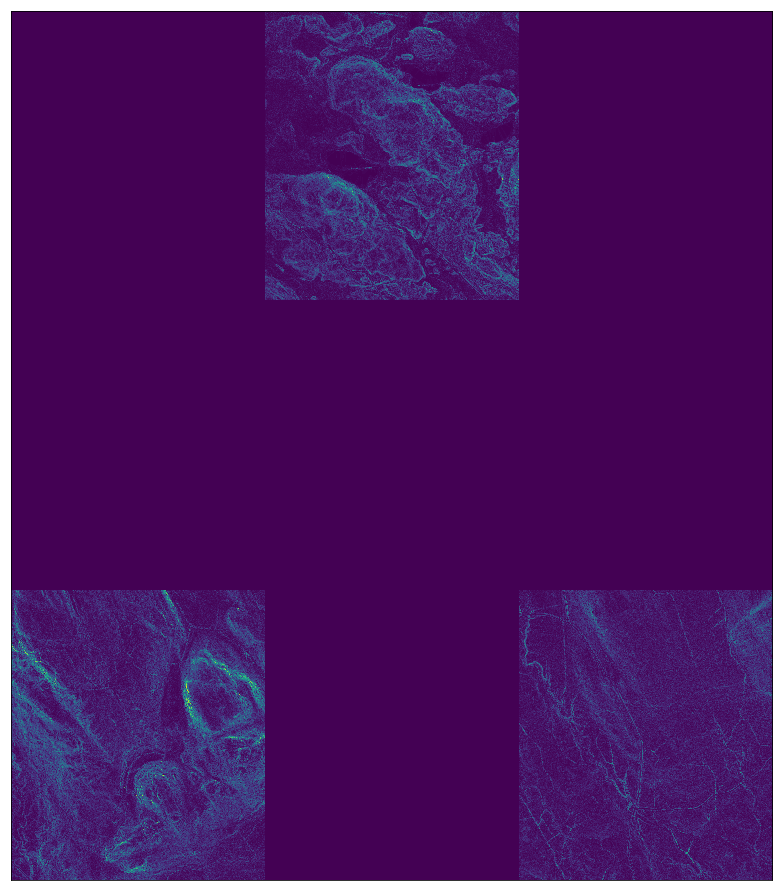

In [18]:
plt.figure(num=None, figsize=(28,16), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0)
ax[0].imshow(slopeArr)
plt.savefig('simenebok.eps', format='eps', dpi='figure')
for row in slopeArr:
    for pixel in row:
        print(pixel)
    break

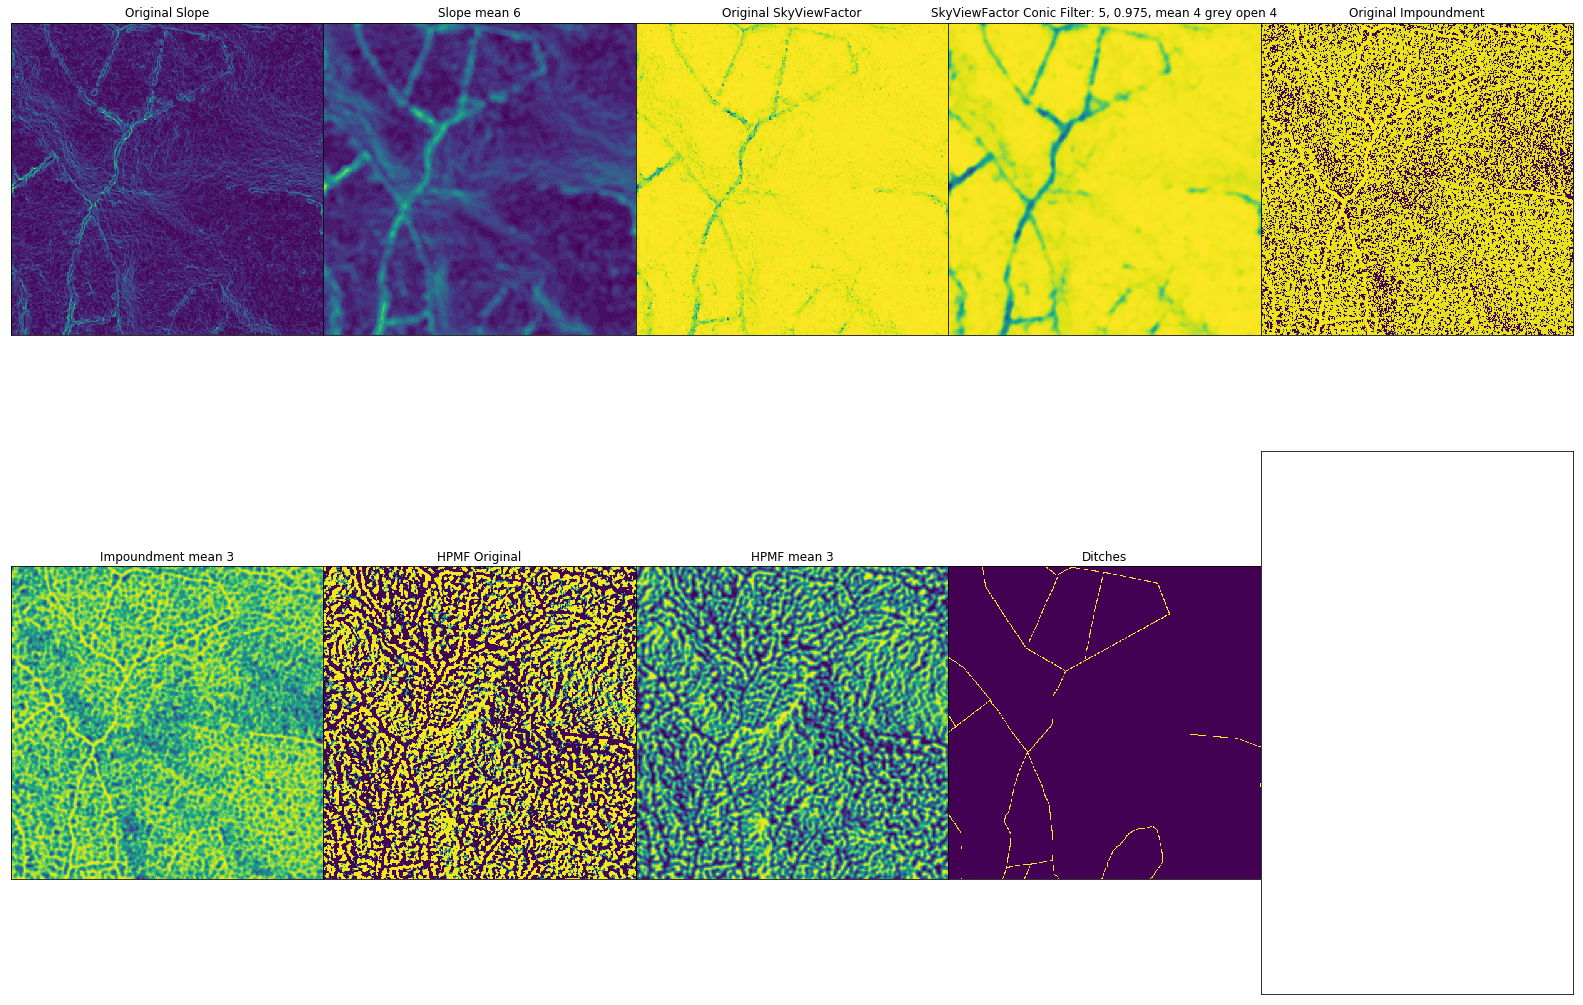

In [99]:
#im = Image.open("../cropped_data/croppedImage_skyview130x130.tif")
#im = Image.open("../cropped_data/croppedImage_skyview200x200.tif")
#im = Image.open("../cropped_data/croppedImage_impoundment400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview2500x2500.tif")
#im = Image.open("../cropped_data/croppedImage_skyview1000x1000.tif")
skyViewIm = Image.open("../cropped_data/croppedImage_Skyview500x500_10299_10601_10799_11101.tif")
skyViewArr = np.asarray(skyViewIm)
slopeIm = Image.open("../cropped_data/croppedImage_Slope500x500.tif")
slopeArr = np.asarray(slopeIm)
impoundmentIm = Image.open("../cropped_data/croppedImage_Impoundment500x500.tif")
impoundmentArr = np.asarray(impoundmentIm)
HPMFIm = Image.open("../cropped_data/croppedImage_HPMF500x500.tif")
HPMFArr = np.asarray(HPMFIm)
ditchesIm = Image.open("../cropped_data/croppedImage_Ditches500x500.tif")
ditchesArr = np.asarray(ditchesIm)

def create_conic_mask(radius, direction):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    if direction == 0: #topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel

def conicMean(arr, maskRadius, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(create_conic_mask(maskRadius, i))
    newArr = arr.copy()
    amountOfThresholds = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            topRight = meanFromMask(arr, (i, j), masks[0])
            rightTop = meanFromMask(arr, (i, j), masks[1])
            rightBottom = meanFromMask(arr, (i, j), masks[2])
            bottomRight = meanFromMask(arr, (i, j), masks[3])
            bottomLeft = meanFromMask(arr, (i, j), masks[4])
            leftBottom = meanFromMask(arr, (i, j), masks[5])
            leftTop = meanFromMask(arr, (i, j), masks[6])
            topLeft = meanFromMask(arr, (i, j), masks[7])
            if topRight < threshold:
                if bottomLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (topRight if topRight < bottomLeft else bottomLeft)
            
            elif rightTop < threshold:
                if leftBottom < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (leftBottom if leftBottom < rightTop else rightTop)
            
            elif rightBottom < threshold:
                if leftTop < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (rightBottom if rightBottom < leftTop else leftTop)
            
            elif bottomRight < threshold:
                if topLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (bottomRight if bottomRight < topLeft else topLeft)
            if newArr[i][j] > arr[i][j]:
                newArr[i][j] = arr[i][j]
    print(amountOfThresholds)        
    return newArr

def meanFromMask(arr, index, mask):
    elementAmount = 0
    row = index[0]
    col = index[1]
    
    halfMask = len(mask) // 2
    
    arrLen = len(arr)
        
    elementSum = 0
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLen - 2 > col + j or col + j >= 0 or arrLen - 2 > row + i or row + i >= 0:
                if mask[i + halfMask][j + halfMask] == 1:
                    #print(row + i)
                    #print(col + j)
                    if row + i < arrLen:
                        if col + j < arrLen:
                            elementSum += arr[row + i][col + j]
                            elementAmount += 1
    #if col > 123 and row > 123:
        #print(elementSum)
        #print(elementAmount)
        #print("\n")
    return elementSum / elementAmount if elementAmount != 0 else 0.99

'''
plt.figure(num=None, figsize=(28,16), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,4,i+1) for i in range(8)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0)

ax[0].title.set_text("Top Right")
ax[0].imshow(create_conic_mask(40, 0))
ax[1].title.set_text("Right Top")
ax[1].imshow(create_conic_mask(40, 1))
ax[2].title.set_text("Right Bottom")
ax[2].imshow(create_conic_mask(40, 2))
ax[3].title.set_text("Bottom Right")
ax[3].imshow(create_conic_mask(40, 3))
ax[4].title.set_text("Bottom Left")
ax[4].imshow(create_conic_mask(40, 4))
ax[5].title.set_text("Left Bottom")
ax[5].imshow(create_conic_mask(40, 5))
ax[6].title.set_text("Left Top")
ax[6].imshow(create_conic_mask(40, 6))
ax[7].title.set_text("Top Left")
ax[7].imshow(create_conic_mask(40, 7))
'''

'''
newConicArr = conicMean(skyViewArr, 5, 0.975)

circ_mask3 = create_circular_mask(3)
circ_mask4 = create_circular_mask(4)
circ_mask6 = create_circular_mask(6)
circ_mask15 = create_circular_mask(15)
circ_mask25 = create_circular_mask(25)

meanGreyOpen = morph.grey_opening(gf(newConicArr,np.nanmean,footprint=circ_mask4), footprint=circ_mask4)

np.save("hpmf_feature500.npy", gf(HPMFArr,np.nanmean,footprint=circ_mask3))
np.save("slope_feature500.npy", gf(slopeArr,np.nanmean,footprint=circ_mask6))
np.save("impoundment_feature500.npy", gf(impoundmentArr,np.nanmean,footprint=circ_mask3))
np.save("skyview_feature500.npy", meanGreyOpen)

'''

hpmf = np.load("hpmf_feature500.npy")
slope = np.load("slope_feature500.npy")
impoundment = np.load("impoundment_feature500.npy")
skyview = np.load("skyview_feature500.npy")



plt.figure(num=None, figsize=(28,20), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,5,i+1) for i in range(10)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0)


ax[0].title.set_text("Original Slope")
ax[0].imshow(slopeArr)

ax[1].title.set_text("Slope mean 6")
ax[1].imshow(slope)

ax[2].title.set_text("Original SkyViewFactor")
ax[2].imshow(skyViewArr)

ax[3].title.set_text("SkyViewFactor Conic Filter: 5, 0.975, mean 4 grey open 4")
ax[3].imshow(skyview)

ax[4].title.set_text("Original Impoundment")
ax[4].imshow(impoundmentArr)

ax[5].title.set_text("Impoundment mean 3")
ax[5].imshow(impoundment)

ax[6].title.set_text("HPMF Original")
ax[6].imshow(HPMFArr)

ax[7].title.set_text("HPMF mean 3")
ax[7].imshow(hpmf)

ax[8].title.set_text("Ditches")
ax[8].imshow(ditchesArr)

#ax[2].title.set_text("Conic Filter 5, 0.975, circ 4 mean_grey_opening")
#ax[2].imshow(meanGreyOpen)

#plt.savefig('conic_test_2500x2500.eps', format='eps', dpi='figure')